# Playing with poverty models

So the idea for this notebook is to play with different classification models to predict poverty on a city level. This uses specifically US data from the Census thus, poverty is defined within the context of the data provided by the Census bureau. So note that depending on the state, and the family size (which includes 1, an individual) the poverty line changes. For example, the ASPE office of HHS (found here: https://aspe.hhs.gov/poverty-guidelines) a household of 1 person with an income of <= $12,140 is considered below with the poverty level.

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC 
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression


from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

%matplotlib inline

lets have some fun and take a look at our data

In [2]:
from xgboost import XGBClassifier

In [3]:
df = pd.read_csv("../csv/city_pov_2016.csv", encoding="latin-1")

Not too big (but not too small either :D)

In [4]:
df.shape

(605, 49)

We'll print out the columns of our dataset just so we can take a look at it for reference

In [5]:
df.columns

Index(['Id', 'Id2', 'Geography',
       'Estimate; EMPLOYMENT STATUS - Population 16 years and over',
       'Estimate; EMPLOYMENT STATUS - Civilian labor force',
       'Percent; EMPLOYMENT STATUS - Civilian labor force - Unemployment Rate',
       'Estimate; OCCUPATION - Civilian employed population 16 years and over',
       'Estimate; OCCUPATION - Civilian employed population 16 years and over - Management, business, science, and arts occupations',
       'Percent; OCCUPATION - Civilian employed population 16 years and over - Management, business, science, and arts occupations',
       'Estimate; OCCUPATION - Civilian employed population 16 years and over - Service occupations',
       'Percent; OCCUPATION - Civilian employed population 16 years and over - Service occupations',
       'Estimate; OCCUPATION - Civilian employed population 16 years and over - Sales and office occupations',
       'Percent; OCCUPATION - Civilian employed population 16 years and over - Sales and office 

So how do we classify a city as poor? Well for now, I'll use the column labeled 'Percent; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - All people', (wow that's a mouth full). Why? Because it is a basic and comprehensive way of showing the average level of poverty across cities in the US.

In [6]:
df['Percent; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - All people'].describe()

count    605.000000
mean      15.712397
std        7.732579
min        2.000000
25%        9.600000
50%       15.000000
75%       20.400000
max       47.400000
Name: Percent; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - All people, dtype: float64

Probably should've done this earlier, but lets just change the column name I've used above. Make things look better ya dig?

In [7]:
df.rename(columns={'Percent; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - All people': 'Per_below_pov'}, inplace=True)

In [8]:
df['Per_below_pov'].head()

0    24.5
1    19.6
2     5.4
3    17.3
4    21.4
Name: Per_below_pov, dtype: float64

So it appears, just based off this very basic describe method, that the average percentage of people below the poverty level in US cities in around 16% 


Now is the fun part, we get to play with and develop some models. Now, we'll say that any city with more than 16% of its population below the poverty line is considered relatively poor within the context of the United States. We could use Sci-Kit Learn's LabelEncoder, but, for simplicity sake, I'll just convert any values below 16% to 0 and above to 1 using pandas. 

In [9]:
df.loc[df['Per_below_pov'] <= 13, "is_poor"] = 1
df.loc[df['Per_below_pov'] > 13, "is_poor"] = 0

In [10]:
df['is_poor'].head()

0    0.0
1    0.0
2    1.0
3    0.0
4    0.0
Name: is_poor, dtype: float64

Purrrrrfect  ;) .  Anyway now lets check our dataset for missing values, we'll replace those with zeros for now. 

In [11]:
df.isnull().sum().sum()

0

In [12]:
df = df.replace("N", np.nan)

In [13]:
df = df.fillna('0')

Lets do some preliminary work. We'll create our test splits right now.

lets find the distribution of poor cities

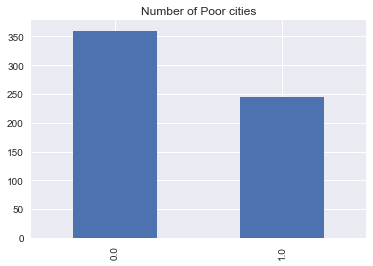

In [14]:
df['is_poor'].value_counts().plot.bar(title='Number of Poor cities')


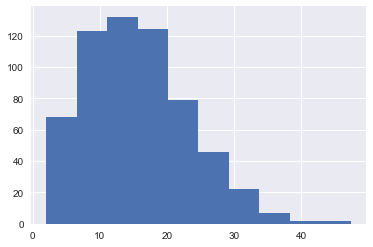

In [15]:
df['Per_below_pov'].hist()

In [16]:
target = df["is_poor"]
target_names = ["poorer", "wealthier"]
data = df.drop(["is_poor", 'Geography', 'Id', 'Id2'], axis=1)
feature_names = data.columns

In [17]:
X_train, X_test, y_train, y_test = train_test_split(data, target, random_state=32)

I want to start with a SVC, lets try it now.
SVC
========

In [18]:
X_train, X_test, y_train, y_test = train_test_split(data, target, random_state=32)
X_scaler = StandardScaler().fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [19]:

svc_model = SVC(kernel='linear')

In [20]:
#from sklearn.model_selection import GridSearchCV
#param_grid = {'C': [1, 10],
#              'gamma': [0.0001, 0.001]}
#grid = GridSearchCV(svc, param_grid, verbose=2)

In [21]:
#grid.fit(X_train, y_train)

fit the model

In [22]:
#X_train, X_test, y_train, y_test = train_test_split(data, target, random_state=32)

In [23]:
svc_model.fit(X_train_scaled, y_train)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [24]:
print('Test Acc: %.3f' % svc_model.score(X_test, y_test))

Test Acc: 0.375


In [25]:
MSE_svc = mean_squared_error(y_test, svc_model.predict(X_test))  
print(f"MSE: {MSE_svc}")

MSE: 0.625


In [26]:
predictions = svc_model.predict(X_test_scaled)
print(classification_report(y_test, predictions,
                            target_names=target_names))

             precision    recall  f1-score   support

     poorer       0.97      0.98      0.97        95
  wealthier       0.96      0.95      0.96        57

avg / total       0.97      0.97      0.97       152



Grid Search
===========

In [27]:
X_train, X_test, y_train, y_test = train_test_split(data, target, random_state=32)
X_scaler = StandardScaler().fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [28]:
svc_model1 = SVC(kernel='linear')

In [29]:
from sklearn.model_selection import GridSearchCV
param_grid = {'C': [1, 5, 10],
              'gamma': [0.0001, 0.001, 0.01]}
grid = GridSearchCV(svc_model1, param_grid, verbose=2)

In [30]:
grid.fit(X_train_scaled, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] C=1, gamma=0.0001 ...............................................
[CV] ................................ C=1, gamma=0.0001, total=   0.0s
[CV] C=1, gamma=0.0001 ...............................................
[CV] ................................ C=1, gamma=0.0001, total=   0.0s
[CV] C=1, gamma=0.0001 ...............................................
[CV] ................................ C=1, gamma=0.0001, total=   0.0s
[CV] C=1, gamma=0.001 ................................................
[CV] ................................. C=1, gamma=0.001, total=   0.0s
[CV] C=1, gamma=0.001 ................................................
[CV] ................................. C=1, gamma=0.001, total=   0.0s
[CV] C=1, gamma=0.001 ................................................
[CV] ................................. C=1, gamma=0.001, total=   0.0s
[CV] C=1, gamma=0.01 .................................................
[CV] ............

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ................................. C=10, gamma=0.01, total=   0.0s


[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:    0.2s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': [1, 5, 10], 'gamma': [0.0001, 0.001, 0.01]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=2)

In [31]:
print('Test Acc: %.3f' % grid.score(X_test, y_test))

Test Acc: 0.375


In [32]:
predictions = grid.predict(X_test_scaled)
print(classification_report(y_test, predictions,
                            target_names=target_names))

             precision    recall  f1-score   support

     poorer       0.97      0.98      0.97        95
  wealthier       0.96      0.95      0.96        57

avg / total       0.97      0.97      0.97       152





K-Nearest Neighbors
==================================

In [33]:
X_train, X_test, y_train, y_test = train_test_split(data, target, random_state=32)
X_scaler = StandardScaler().fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

k: 1, Train/Test Score: 1.000/0.829
k: 3, Train/Test Score: 0.923/0.868
k: 5, Train/Test Score: 0.916/0.875
k: 7, Train/Test Score: 0.896/0.875
k: 9, Train/Test Score: 0.898/0.888
k: 11, Train/Test Score: 0.898/0.895
k: 13, Train/Test Score: 0.881/0.882
k: 15, Train/Test Score: 0.881/0.888
k: 17, Train/Test Score: 0.879/0.888
k: 19, Train/Test Score: 0.883/0.882


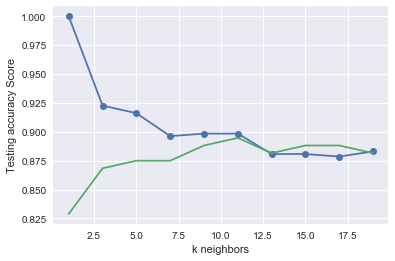

In [34]:
# Loop through different k values to see which has the highest accuracy
# Note: We only use odd numbers because we don't want any ties
train_scores = []
test_scores = []
for k in range(1, 20, 2):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    train_score = knn.score(X_train_scaled, y_train)
    test_score = knn.score(X_test_scaled, y_test)
    train_scores.append(train_score)
    test_scores.append(test_score)
    print(f"k: {k}, Train/Test Score: {train_score:.3f}/{test_score:.3f}")
    
    
plt.plot(range(1, 20, 2), train_scores, marker='o')
plt.plot(range(1, 20, 2), test_scores, marker="x")
plt.xlabel("k neighbors")
plt.ylabel("Testing accuracy Score")
plt.show()

Random Forest Classifier
================================

In [35]:
X_train, X_test, y_train, y_test = train_test_split(data, target, random_state=32)

In [36]:
X_scaler = StandardScaler().fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [37]:
rf = RandomForestClassifier(n_estimators=50, random_state=32)
rf.fit(X_train_scaled, y_train)
rf.score(X_test_scaled, y_test)

0.993421052631579

In [38]:
predictions = rf.predict(X_test_scaled)
print(classification_report(y_test, predictions,
                            target_names=target_names))

             precision    recall  f1-score   support

     poorer       0.99      1.00      0.99        95
  wealthier       1.00      0.98      0.99        57

avg / total       0.99      0.99      0.99       152



In [39]:
MSE_rf = mean_squared_error(y_test, rf.predict(X_test))  
print(f"MSE: {MSE_rf}")

MSE: 0.375


In [40]:
print('Test Acc: %.3f' % rf.score(X_test, y_test))

Test Acc: 0.625


Gradient Boosting Classifier
====================

In [41]:
X_train, X_test, y_train, y_test = train_test_split(data, target, random_state=32)
X_scaler = StandardScaler().fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [42]:
gbc = GradientBoostingClassifier(n_estimators=2, random_state=32)
gbc.fit(X_train_scaled, y_train)
gbc.score(X_test_scaled, y_test)
print('Test Acc: %.3f' % gbc.score(X_test, y_test))

Test Acc: 0.625


In [43]:
MSE_gbc = mean_squared_error(y_test, gbc.predict(X_test))  
print(f"MSE: {MSE_gbc}")

MSE: 0.375


In [44]:
predictions = gbc.predict(X_test_scaled)
print(classification_report(y_test, predictions,
                            target_names=target_names))

             precision    recall  f1-score   support

     poorer       1.00      1.00      1.00        95
  wealthier       1.00      1.00      1.00        57

avg / total       1.00      1.00      1.00       152



Logistic Regression
===========

In [45]:
X_train, X_test, y_train, y_test = train_test_split(data, target, random_state=32)
X_scaler = StandardScaler().fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [46]:
lrc = LogisticRegression()

In [47]:
lrc.fit(X_train_scaled, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [48]:
print('Test Acc: %.3f' % lrc.score(X_test, y_test))

Test Acc: 0.375


In [49]:
predictions = lrc.predict(X_test_scaled)
print(classification_report(y_test, predictions,
                            target_names=target_names))

             precision    recall  f1-score   support

     poorer       0.97      0.94      0.95        95
  wealthier       0.90      0.95      0.92        57

avg / total       0.94      0.94      0.94       152



XGBoost
==========

In [50]:
from numpy import loadtxt
from sklearn.metrics import accuracy_score


In [51]:
X_train, X_test, y_train, y_test = train_test_split(data, target, random_state=32)


In [52]:
xgb_model = XGBClassifier()
xgb_model.fit(X_train_scaled, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [53]:
y_pred = xgb_model.predict(X_test_scaled)
predictions = [round(value) for value in y_pred]

/Users/jayklein95/anaconda/envs/PythonData/lib/python3.6/site-packages/sklearn/preprocessing/label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [54]:
accuracy = accuracy_score(y_test_x, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 100.00%


In [55]:
print(classification_report(y_test, predictions,
                            target_names=target_names))

             precision    recall  f1-score   support

     poorer       1.00      1.00      1.00        95
  wealthier       1.00      1.00      1.00        57

avg / total       1.00      1.00      1.00       152

